In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import numpy as np

from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2

In [2]:
# load API keys
from dotenv import load_dotenv
import os

load_dotenv()
QR_TOKEN = os.getenv("QR_TOKEN")
QR_NAME = os.getenv("QR_NAME")

# Acquire the Quantum Rings Provider
qr_provider = QuantumRingsProvider(token=QR_TOKEN, name=QR_NAME)

In [3]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

In [4]:
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N) 
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=np.power(2.0, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    # TODO: check if this is the same
    #circuit.cu1(angle/2,ctl1,tgt)
    circuit.cp(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cp(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(angle/2,ctl2,tgt)
    circuit.cp(angle/2,ctl2,tgt)

In [5]:
def create_QFT(circuit : QuantumCircuit, up_reg : QuantumRegister, n, with_swaps):
    i = n - 1
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    while i >= 0:
        circuit.h(up_reg[i])
        j = i - 1
        while j >= 0:
            if (np.pi) / (pow(2, (i - j))) > 0:
                # TODO: check cp cu1
                #circuit.cu1((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                circuit.cp((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                j = j - 1
        i = i - 1

    """ If specified, apply the Swaps at the end """
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

def create_inverse_QFT(circuit, up_reg, n, with_swaps):
    """If specified, apply the Swaps at the beggining"""
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i = 0
    while i < n:
        circuit.h(up_reg[i])
        if i != n - 1:
            j = i + 1
            y = i
            while y >= 0:
                if (np.pi) / (pow(2, (j - y))) > 0:
                    # TODO: check cu1 u1
                    #circuit.cu1(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    circuit.cp(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    y = y - 1
        i = i + 1

In [6]:
"""Creation of the circuit that performs addition by a in Fourier Space"""

"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""


def phiADD(circuit, q, a, N, inv):
    angle = getAngles(a, N)
    for i in range(0, N):
        # TODO: check u1 p
        if inv == 0:
            #circuit.u1(angle[i], q[i])
            circuit.p(angle[i], q[i])
        else:
            #circuit.u1(-angle[i], q[i])
            circuit.p(-angle[i], q[i])


"""Single controlled version of the phiADD circuit"""


def cphiADD(circuit, q, ctl, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        # TODO: check cp cu1
        if inv == 0:
            #circuit.cu1(angle[i], ctl, q[i])
            circuit.cp(angle[i], ctl, q[i])
        else:
            #circuit.cu1(-angle[i], ctl, q[i])
            circuit.cp(-angle[i], ctl, q[i])


"""Doubly controlled version of the phiADD circuit"""


def ccphiADD(circuit, q, ctl1, ctl2, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        if inv == 0:
            ccphase(circuit, angle[i], ctl1, ctl2, q[i])
        else:
            ccphase(circuit, -angle[i], ctl1, ctl2, q[i])


"""Circuit that implements doubly controlled modular addition by a"""


def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    cphiADD(circuit, q, aux, N, n, 0)

    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)


"""Circuit that implements the inverse of doubly controlled modular addition by a"""


def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

In [7]:
def cMULTmodN(circuit : QuantumCircuit, ctl, q, aux, a, semiprime, circuit_size):
    create_QFT(circuit,aux,circuit_size+1,0)
    """Circuit that implements single controlled modular multiplication by a"""
    for i in range(0, circuit_size):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[circuit_size+1], (2**i)*a % semiprime, semiprime, circuit_size+1)
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)

    for i in range(0, circuit_size):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, semiprime)
    create_QFT(circuit, aux, circuit_size+1, 0)
    i = circuit_size - 1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[circuit_size+1], np.power(2,i) * a_inv % semiprime, semiprime, circuit_size+1)
        i -= 1
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)


In [8]:
semiprime = 15
base = 7 # TODO: implement coprime checker
circuit_size = np.ceil(np.log2(semiprime)).astype(int)

In [9]:
# auxilliary quantum register used in addition and multiplication
aux = QuantumRegister(circuit_size+2)
# quantum register where the sequential QFT is performed
up_reg = QuantumRegister(2*circuit_size)
# quantum register where the multiplications are made
down_reg = QuantumRegister(circuit_size)
# classical register where the measured values of the QFT are stored
up_classic = ClassicalRegister(2*circuit_size)

In [10]:
circuit = QuantumCircuit(down_reg, up_reg, aux, up_classic)
# Initialize down register to 1 and create maximal superposition in top register
circuit.h(up_reg)
circuit.x(down_reg[0])

In [11]:
# Apply the multiplication gates as showed in the report in order to create the exponentiation """
for i in range(0, 2*circuit_size):
    cMULTmodN(circuit, up_reg[i], down_reg, aux, int(pow(base, pow(2, i))), semiprime, circuit_size)

In [12]:
# Apply inverse QFT
create_inverse_QFT(circuit, up_reg, 2 * circuit_size, 1)

In [13]:
# Measure the top qubits, to get period 
circuit.measure(up_reg,up_classic)

In [14]:
circuit.num_qubits

18

In [15]:
# transpile circuit to Quantum Rings backend
qr_backend = QrBackendV2(qr_provider, num_qubits = circuit.num_qubits)
qc_transpiled = transpile(circuit, qr_backend, initial_layout=[i for i in range(0, circuit.num_qubits)])

In [16]:
# Execute the quantum code
job = qr_backend.run(qc_transpiled, shots = 1024)

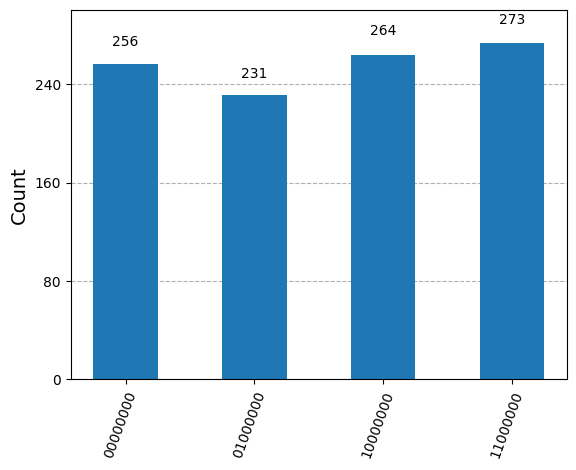

In [17]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)